In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, KFold
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [37]:
%%time
train = pd.read_csv("train.csv")

Wall time: 14 ms


In [38]:
train.shape

(891, 12)

In [39]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [40]:
#Cabinの頭文字で分類する。
for num, (cb) in enumerate(train["Cabin"]):
    try:
        train.at[num, "Cabin"] =  re.findall("^[^0-9]",cb)[0]
    except TypeError as err:
        train.at[num, "Cabin"] =  cb

train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [41]:
#Cabinの頭文字がTの行。(testデータには存在しない。)
for num_T, (cb_T) in enumerate(train["Cabin"]):
    if cb_T == "T":
        print(num_T)

339


In [42]:
train.loc[339]

PassengerId                             340
Survived                                  0
Pclass                                    1
Name           Blackwell, Mr. Stephen Weart
Sex                                    male
Age                                      45
SibSp                                     0
Parch                                     0
Ticket                               113784
Fare                                   35.5
Cabin                                     T
Embarked                                  S
Name: 339, dtype: object

In [43]:
#一部データ列を取り除く
train_dr = train.drop(["Name","Ticket","PassengerId"], axis=1)
#ワンホットエンコーディング
train_dmm =pd.get_dummies(train_dr)
train_dmm.columns

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female',
       'Sex_male', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
       'Cabin_F', 'Cabin_G', 'Cabin_T', 'Embarked_C', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')

In [44]:
train_dmm.head(10)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,0,0,0,0,0,0,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,0,0,1,0,0,0,0,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,0,0,0,0,0,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1,0,0,0,0,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,0,0,0,0,0,0,0,0,1
5,0,3,NaN,0,0,8.4583,0,1,0,0,0,0,0,0,0,0,0,1,0
6,0,1,54.0,0,0,51.8625,0,1,0,0,0,0,1,0,0,0,0,0,1
7,0,3,2.0,3,1,21.0750,0,1,0,0,0,0,0,0,0,0,0,0,1
8,1,3,27.0,0,2,11.1333,1,0,0,0,0,0,0,0,0,0,0,0,1
9,1,2,14.0,1,0,30.0708,1,0,0,0,0,0,0,0,0,0,1,0,0


In [45]:
train_dmm.info()
#age列だけNaNがある。

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Age           714 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Sex_female    891 non-null uint8
Sex_male      891 non-null uint8
Cabin_A       891 non-null uint8
Cabin_B       891 non-null uint8
Cabin_C       891 non-null uint8
Cabin_D       891 non-null uint8
Cabin_E       891 non-null uint8
Cabin_F       891 non-null uint8
Cabin_G       891 non-null uint8
Cabin_T       891 non-null uint8
Embarked_C    891 non-null uint8
Embarked_Q    891 non-null uint8
Embarked_S    891 non-null uint8
dtypes: float64(2), int64(4), uint8(13)
memory usage: 53.2 KB


In [46]:
#特徴量(x)と結果(y)に分ける。
train_x = train_dmm.drop(["Survived"], axis=1)
train_y = train_dmm["Survived"]

In [47]:
train_x.head(10)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,0,0,0,0,0,0,0,0,1
1,1,38.0,1,0,71.2833,1,0,0,0,1,0,0,0,0,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,0,0,0,0,0,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1,0,0,0,0,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,0,0,0,0,0,0,0,0,1
5,3,NaN,0,0,8.4583,0,1,0,0,0,0,0,0,0,0,0,1,0
6,1,54.0,0,0,51.8625,0,1,0,0,0,0,1,0,0,0,0,0,1
7,3,2.0,3,1,21.0750,0,1,0,0,0,0,0,0,0,0,0,0,1
8,3,27.0,0,2,11.1333,1,0,0,0,0,0,0,0,0,0,0,0,1
9,2,14.0,1,0,30.0708,1,0,0,0,0,0,0,0,0,0,1,0,0


In [48]:
train_y[0:10]

0    0
1    1
2    1
3    1
4    0
5    0
6    0
7    0
8    1
9    1
Name: Survived, dtype: int64

In [49]:
#欠損しているageの予想を行う。

#ageのNaNになっているところだけ抽出。(testデータ)
train_pred_age = train_x[train_x["Age"].isnull()]

In [50]:
train_pred_age.head(10)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
5,3,NaN,0,0,8.4583,0,1,0,0,0,0,0,0,0,0,0,1,0
17,2,NaN,0,0,13.0000,0,1,0,0,0,0,0,0,0,0,0,0,1
19,3,NaN,0,0,7.2250,1,0,0,0,0,0,0,0,0,0,1,0,0
26,3,NaN,0,0,7.2250,0,1,0,0,0,0,0,0,0,0,1,0,0
28,3,NaN,0,0,7.8792,1,0,0,0,0,0,0,0,0,0,0,1,0
29,3,NaN,0,0,7.8958,0,1,0,0,0,0,0,0,0,0,0,0,1
31,1,NaN,1,0,146.5208,1,0,0,1,0,0,0,0,0,0,1,0,0
32,3,NaN,0,0,7.7500,1,0,0,0,0,0,0,0,0,0,0,1,0
36,3,NaN,0,0,7.2292,0,1,0,0,0,0,0,0,0,0,1,0,0
42,3,NaN,0,0,7.8958,0,1,0,0,0,0,0,0,0,0,1,0,0


In [51]:
#特徴量(x)と結果(y)に分ける。
train_pred_age_x = train_pred_age.drop(["Age"], axis=1)
train_pred_age_y = pd.Series(np.zeros(train_pred_age["Age"].shape))

In [52]:
train_pred_age_y.shape

(177,)

In [53]:
train_pred_age_y.head(10)

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
dtype: float64

In [54]:
#ageのNaNになっていないところだけ抽出。(trainデータ)
train_tr_age = train_x[train_x["Age"].notnull()]

In [55]:
train_tr_age.shape

(714, 18)

In [56]:
#特徴量(x)と結果(y)に分ける。
train_tr_age_x = train_tr_age.drop(["Age"], axis=1)
train_tr_age_y = train_tr_age["Age"]

In [57]:
train_tr_age_x.head(10)

,Pclass,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
0,3,1,0,7.2500,0,1,0,0,0,0,0,0,0,0,0,0,1
1,1,1,0,71.2833,1,0,0,0,1,0,0,0,0,0,1,0,0
2,3,0,0,7.9250,1,0,0,0,0,0,0,0,0,0,0,0,1
3,1,1,0,53.1000,1,0,0,0,1,0,0,0,0,0,0,0,1
4,3,0,0,8.0500,0,1,0,0,0,0,0,0,0,0,0,0,1
6,1,0,0,51.8625,0,1,0,0,0,0,1,0,0,0,0,0,1
7,3,3,1,21.0750,0,1,0,0,0,0,0,0,0,0,0,0,1
8,3,0,2,11.1333,1,0,0,0,0,0,0,0,0,0,0,0,1
9,2,1,0,30.0708,1,0,0,0,0,0,0,0,0,0,1,0,0
10,3,1,1,16.7000,1,0,0,0,0,0,0,0,1,0,0,0,1


In [58]:
train_tr_age_y.head(10)

0     22.0
1     38.0
2     26.0
3     35.0
4     35.0
6     54.0
7      2.0
8     27.0
9     14.0
10     4.0
Name: Age, dtype: float64

In [59]:
#ageの空白部分を埋めるモデル
model_age = lgb.LGBMRegressor() 

In [60]:
#交差検証
folds = KFold(n_splits=5, shuffle=True, random_state=33)

In [61]:
# パラメーターを設定する
param_grid_age = {"max_depth": [10, 20, 30, 40, 50],
              "learning_rate" : [0.001,0.01,0.05,0.1],
              "num_leaves": [30,50,100,300, 500],
              "n_estimators": [100,200,500]
             }
# パラメータチューニングをグリッドサーチで行う。
grid_result = GridSearchCV(estimator = model_age,
                           param_grid = param_grid_age,
                           scoring = 'neg_mean_absolute_error',
                           cv = folds,
                           verbose=3,
                           return_train_score = True,
                           n_jobs = -1)

grid_result.fit(train_tr_age_x, train_tr_age_y)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 832 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1408 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  1.2min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=33, shuffle=True),
       error_score='raise-deprecating',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [10, 20, 30, 40, 50], 'learning_rate': [0.001, 0.01, 0.05, 0.1], 'num_leaves': [30, 50, 100, 300, 500], 'n_estimators': [100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=3)

In [62]:
grid_result.best_params_

{'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500, 'num_leaves': 30}

In [63]:
grid_result.best_score_

-9.891487711864269

In [64]:
#求めたパラメータで予想。
params = {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500, 'num_leaves': 30}
model_age_pred = lgb.LGBMRegressor(**params, n_jobs = -1)
model_age_pred.fit(train_tr_age_x, train_tr_age_y)
y_pred_tr = model_age_pred.predict(train_tr_age_x)


In [65]:
#NaNになっているageを予想。
train_pred_age_y = model_age_pred.predict(train_pred_age_x)

In [66]:
train_pred_age_y.shape

(177,)

In [67]:
train_pred_age_y[0:10]

array([31.55414061, 32.71430965, 16.54586483, 27.50567005, 23.96688787,
       27.823394  , 32.24853221, 27.33849843, 26.18497045, 28.04205644])

In [68]:
train_pred_age_y[-5:-1]

array([26.18497045, 11.42117605, 26.46055154, 27.823394  ])

In [69]:
#予想したageをtrainデータに反映。
train_x.loc[train_x["Age"].isnull(), 'Age'] = train_pred_age_y

In [70]:
train_x.info()
#NaNを埋めることができた。

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
Pclass        891 non-null int64
Age           891 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Sex_female    891 non-null uint8
Sex_male      891 non-null uint8
Cabin_A       891 non-null uint8
Cabin_B       891 non-null uint8
Cabin_C       891 non-null uint8
Cabin_D       891 non-null uint8
Cabin_E       891 non-null uint8
Cabin_F       891 non-null uint8
Cabin_G       891 non-null uint8
Cabin_T       891 non-null uint8
Embarked_C    891 non-null uint8
Embarked_Q    891 non-null uint8
Embarked_S    891 non-null uint8
dtypes: float64(2), int64(3), uint8(13)
memory usage: 46.2 KB


In [71]:
train_x.head(10)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
0,3,22.000000,1,0,7.2500,0,1,0,0,0,0,0,0,0,0,0,0,1
1,1,38.000000,1,0,71.2833,1,0,0,0,1,0,0,0,0,0,1,0,0
2,3,26.000000,0,0,7.9250,1,0,0,0,0,0,0,0,0,0,0,0,1
3,1,35.000000,1,0,53.1000,1,0,0,0,1,0,0,0,0,0,0,0,1
4,3,35.000000,0,0,8.0500,0,1,0,0,0,0,0,0,0,0,0,0,1
5,3,31.554141,0,0,8.4583,0,1,0,0,0,0,0,0,0,0,0,1,0
6,1,54.000000,0,0,51.8625,0,1,0,0,0,0,1,0,0,0,0,0,1
7,3,2.000000,3,1,21.0750,0,1,0,0,0,0,0,0,0,0,0,0,1
8,3,27.000000,0,2,11.1333,1,0,0,0,0,0,0,0,0,0,0,0,1
9,2,14.000000,1,0,30.0708,1,0,0,0,0,0,0,0,0,0,1,0,0


In [72]:
#交差検証
#結果の比率が同じになるように分割
skf = StratifiedKFold(n_splits=5,
                      shuffle=True,
                      random_state=0)

In [73]:
#survivedを予想するモデル
model = lgb.LGBMClassifier()

In [74]:
%%time
# パラメーターを設定する
param_grid = {"max_depth": [10, 20, 30, 40, 50],
              "learning_rate" : [0.001,0.01,0.05,0.1],
              "num_leaves": [30,50,100,300, 500],
              "n_estimators": [100,200,500]
             }
# パラメータチューニングをグリッドサーチで行う
grid_result = GridSearchCV(estimator = model,
                           param_grid = param_grid,
                           scoring = 'balanced_accuracy',
                           cv = skf,
                           verbose=3,
                           return_train_score = True,
                           n_jobs = -1)

grid_result.fit(train_x, train_y)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 592 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 1152 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  1.8min finished


Wall time: 1min 47s


In [75]:
grid_result.best_params_

{'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 500, 'num_leaves': 30}

In [76]:
grid_result.best_score_

0.8181272093076556

In [77]:
#求めたパラメータで予想。
params = {'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 500, 'num_leaves': 30}
model = lgb.LGBMClassifier(**params, n_jobs = -1)
model.fit(train_x, train_y)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.01, max_depth=20,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=500, n_jobs=-1, num_leaves=30, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

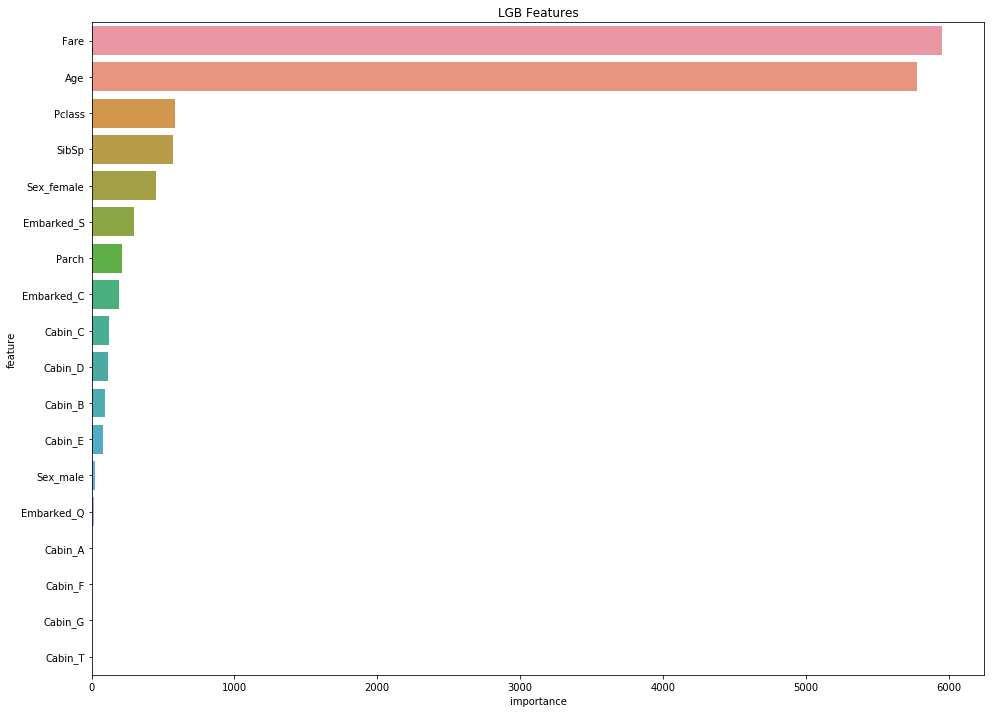

In [78]:
#feature importance
importance = pd.DataFrame()
importance["feature"] = train_x.columns
importance["importance"] = model.feature_importances_

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=importance.sort_values(by="importance", ascending=False));
plt.title('LGB Features');

In [79]:
#テストデータを読み込む。
test_ = pd.read_csv("test.csv")
test_.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


In [80]:
#Cabinが"T"のデータを後ろに追加
#(Trainにはない特徴量を補うため。)
#(のちに削除する。)
s = train.loc[339]
test_tmp = test_.append(s)
test = test_tmp.reset_index()

In [81]:
test.tail(5)

,index,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
414,414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,NaN
415,415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,NaN
416,416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,NaN
417,417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C,NaN
418,339,340,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5000,T,S,0.0


In [82]:
#Cabinの頭文字で分類する。
for num, (cb) in enumerate(test["Cabin"]):
    try:
        test.at[num, "Cabin"] =  re.findall("^[^0-9]",cb)[0]
    except TypeError as err:
        test.at[num, "Cabin"] =  cb

In [83]:
#一部データ列を取り除く
test_dr = test.drop(["Name","Ticket","PassengerId","Survived","index"], axis=1)
#ワンホットエンコーディング
test_x_tmp =pd.get_dummies(test_dr)
test_x_tmp.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male',
       'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_T', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [84]:
#trainから追加したデータ行を削除する。
test_x = test_x_tmp.drop([418])

In [85]:
test_x.tail(10)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
408,3,NaN,0,0,7.7208,1,0,0,0,0,0,0,0,0,0,0,1,0
409,3,3.0,1,1,13.7750,1,0,0,0,0,0,0,0,0,0,0,0,1
410,3,NaN,0,0,7.7500,1,0,0,0,0,0,0,0,0,0,0,1,0
411,1,37.0,1,0,90.0000,1,0,0,0,1,0,0,0,0,0,0,1,0
412,3,28.0,0,0,7.7750,1,0,0,0,0,0,0,0,0,0,0,0,1
413,3,NaN,0,0,8.0500,0,1,0,0,0,0,0,0,0,0,0,0,1
414,1,39.0,0,0,108.9000,1,0,0,0,1,0,0,0,0,0,1,0,0
415,3,38.5,0,0,7.2500,0,1,0,0,0,0,0,0,0,0,0,0,1
416,3,NaN,0,0,8.0500,0,1,0,0,0,0,0,0,0,0,0,0,1
417,3,NaN,1,1,22.3583,0,1,0,0,0,0,0,0,0,0,1,0,0


In [86]:
test_x.info()
#ageとfareに欠損値がある。

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 18 columns):
Pclass        418 non-null int64
Age           332 non-null float64
SibSp         418 non-null int64
Parch         418 non-null int64
Fare          417 non-null float64
Sex_female    418 non-null uint8
Sex_male      418 non-null uint8
Cabin_A       418 non-null uint8
Cabin_B       418 non-null uint8
Cabin_C       418 non-null uint8
Cabin_D       418 non-null uint8
Cabin_E       418 non-null uint8
Cabin_F       418 non-null uint8
Cabin_G       418 non-null uint8
Cabin_T       418 non-null uint8
Embarked_C    418 non-null uint8
Embarked_Q    418 non-null uint8
Embarked_S    418 non-null uint8
dtypes: float64(2), int64(3), uint8(13)
memory usage: 24.9 KB


In [87]:
#fareの欠損部分を補う。(ほかのデータの平均値)
test_x.loc[test_x["Fare"].isnull(),"Fare"] = np.mean(test_x.loc[test_x["Fare"].notnull(),"Fare"])

In [88]:
#ageの欠損部分を補う。
#欠損部分の抽出。
test_pred_age = test_x[test_x["Age"].isnull()]

In [89]:
test_pred_age.head(10)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
10,3,NaN,0,0,7.8958,0,1,0,0,0,0,0,0,0,0,0,0,1
22,1,NaN,0,0,31.6833,1,0,0,0,0,0,0,0,0,0,0,0,1
29,3,NaN,2,0,21.6792,0,1,0,0,0,0,0,0,0,0,1,0,0
33,3,NaN,1,2,23.4500,1,0,0,0,0,0,0,0,0,0,0,0,1
36,3,NaN,0,0,8.0500,1,0,0,0,0,0,0,0,0,0,0,0,1
39,3,NaN,0,0,56.4958,0,1,0,0,0,0,0,0,0,0,0,0,1
41,1,NaN,0,0,26.5500,0,1,0,0,0,1,0,0,0,0,0,0,1
47,3,NaN,0,0,7.7500,0,1,0,0,0,0,0,0,0,0,0,1,0
54,2,NaN,0,0,15.5792,0,1,0,0,0,0,0,0,0,0,1,0,0
58,3,NaN,1,0,16.1000,0,1,0,0,0,0,0,0,0,0,0,0,1


In [90]:
#age予想のための特徴量(x)と結果(y)を作成。
test_pred_age_x = test_pred_age.drop(["Age"], axis=1)
test_pred_age_y = pd.Series(np.zeros(train_pred_age["Age"].shape))

In [91]:
test_pred_age_x.shape

(86, 17)

In [92]:
test_pred_age_x.columns

Index(['Pclass', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male', 'Cabin_A',
       'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G',
       'Cabin_T', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [93]:
train_pred_age_x.columns

Index(['Pclass', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male', 'Cabin_A',
       'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G',
       'Cabin_T', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [94]:
test_pred_age_y.shape

(177,)

In [95]:
#欠損しているageを予想。(testデータ)
test_pred_age_y = model_age_pred.predict(test_pred_age_x)

In [96]:
#予想したageを反映。
test_x.loc[test_x["Age"].isnull(), 'Age'] = test_pred_age_y

In [97]:
test_x.info()
#欠損値が埋まったことを確認できた。

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 18 columns):
Pclass        418 non-null int64
Age           418 non-null float64
SibSp         418 non-null int64
Parch         418 non-null int64
Fare          418 non-null float64
Sex_female    418 non-null uint8
Sex_male      418 non-null uint8
Cabin_A       418 non-null uint8
Cabin_B       418 non-null uint8
Cabin_C       418 non-null uint8
Cabin_D       418 non-null uint8
Cabin_E       418 non-null uint8
Cabin_F       418 non-null uint8
Cabin_G       418 non-null uint8
Cabin_T       418 non-null uint8
Embarked_C    418 non-null uint8
Embarked_Q    418 non-null uint8
Embarked_S    418 non-null uint8
dtypes: float64(2), int64(3), uint8(13)
memory usage: 24.9 KB


In [98]:
test_x.tail(5)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
413,3,30.589406,0,0,8.0500,0,1,0,0,0,0,0,0,0,0,0,0,1
414,1,39.000000,0,0,108.9000,1,0,0,0,1,0,0,0,0,0,1,0,0
415,3,38.500000,0,0,7.2500,0,1,0,0,0,0,0,0,0,0,0,0,1
416,3,30.589406,0,0,8.0500,0,1,0,0,0,0,0,0,0,0,0,0,1
417,3,20.898260,1,1,22.3583,0,1,0,0,0,0,0,0,0,0,1,0,0


In [99]:
#テストデータで予想。
test_y = model.predict(test_x)

In [100]:
test_y[0:10]

array([0, 0, 0, 0, 0, 1, 1, 0, 1, 0], dtype=int64)

In [101]:
test_y.shape

(418,)

In [102]:
test.tail(5)

,index,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
414,414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,C,NaN
415,415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,NaN
416,416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,NaN
417,417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C,NaN
418,339,340,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5000,T,S,0.0


In [103]:
#提出用データの作成。
test_sub = test.drop([418])
submission = pd.DataFrame(test_sub["PassengerId"])
for num in range(submission.shape[0]):
    submission.loc[num, 'Survived_f'] = test_y[num]    
submission['Survived'] = submission['Survived_f'].astype(np.int64)

In [104]:
submission.shape

(418, 3)

In [105]:
submission2 = submission.drop(["Survived_f"], axis=1)

In [106]:
submission2.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,1
6,898,1
7,899,0
8,900,1
9,901,0


In [108]:
submission2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 2 columns):
PassengerId    418 non-null int64
Survived       418 non-null int64
dtypes: int64(2)
memory usage: 29.8 KB


In [107]:
#提出用のファイルを作成。
submission2.to_csv("submission.csv",index = False)